# Create traffic light database for traffic light classifier

In [273]:
import os
import sys
import yaml


def get_all_labels(input_yaml, test=False):
    """ Gets all labels within label file
    Note that RGB images are 1280x720 and RIIB images are 1280x736.
    :param input_yaml: Path to yaml file
    :param riib: If True, change path to labeled pictures
    :return: images: Labels for traffic lights
    """
    images = yaml.load(open(input_yaml, 'rb').read())

    for i in range(len(images)):
        if test:
            x = images[i]['path'].split('/')
            images[i]['path'] = os.path.abspath(os.path.join(os.path.dirname(input_yaml), 'rgb/test/' + x[-1]))
        else:
            images[i]['path'] = os.path.abspath(os.path.join(os.path.dirname(input_yaml), images[i]['path']))
        
    return images

In [274]:
def read_label_files_create_images(image_labels, tl_images_folder_add):
    light_type = np.zeros(4)
    for elem in image_labels:
        image_read = False
        img = None
        for box in elem['boxes']:
            x1 = int(box['x_min']) if int(box['x_min'])>=0 else 0
            x2 = int(box['x_max'])
            y1 = int(box['y_min']) if int(box['y_min'])>=0 else 0
            y2 = int(box['y_max'])
            x_size = x2-x1
            y_size = y2-y1
            label = box['label']
            occluded = box['occluded']
            if x_size > 16 and y_size >  24 and not occluded:
                if "Green" in label or "green" in label: 
                    light_type[0] += 1
                    if not image_read:
                        img = cv2.imread(elem['path'])
                        image_read = True
                    img_to_write = cv2.resize(img[y1:y2,x1:x2], (32, 32)) 
                    cv2.imwrite(tl_images_folder_add + "/green/" + str(light_type[0]) + ".png", img_to_write)
                if "Yellow" in label or "yellow" in label: 
                    light_type[1] += 1
                    if not image_read:
                        img = cv2.imread(elem['path'])
                        image_read = True
                    img_to_write = cv2.resize(img[y1:y2,x1:x2], (32, 32))
                    cv2.imwrite(tl_images_folder_add + "/yellow/" + str(light_type[1]) + ".png", img_to_write)
                if "Red" in label or "red" in label: 
                    light_type[2] += 1
                    if not image_read:
                        img = cv2.imread(elem['path'])
                        image_read = True
                    img_to_write = cv2.resize(img[y1:y2,x1:x2], (32, 32))
                    cv2.imwrite(tl_images_folder_add + "/red/" + str(light_type[2]) + ".png", img_to_write)
                if "Off" in label or "off" in label: 
                    light_type[3] += 1
                    if not image_read:
                        img = cv2.imread(elem['path'])
                        image_read = True
                    img_to_write = cv2.resize(img[y1:y2,x1:x2], (32, 32))
                    cv2.imwrite(tl_images_folder_add + "/off/" + str(light_type[3]) + ".png", img_to_write)
    return light_type

In [275]:
#for train
label_add = './data/train.yaml'
tl_images_folder_add = './data/traffic_lights/train'

image_labels = get_all_labels(label_add,test = False)
light_types_found = read_label_files_create_images(image_labels, tl_images_folder_add)
print(light_types_found)

#for test
label_add = './data/test.yaml'
tl_images_folder_add = './data/traffic_lights/test'

image_labels = get_all_labels(label_add,test = True)
light_types_found = read_label_files_create_images(image_labels, tl_images_folder_add)
print(light_types_found)

[1127.   54.  587.  107.]
[736.  49. 479.  15.]


# Build classifier to detect state of light

In [364]:
def get_histogram(img, hist_bin_size):
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    data_index = 0
    X = np.zeros((1,(hist_bin_size)*12+1))
    index = 0
    for chnl in range(4):
        if chnl < 3:
            for y_pos_ind in range(3): 
                if y_pos_ind == 0:
                    y1 = 0
                    y2 = 10
                if y_pos_ind == 1:
                    y1 = 10
                    y2 = 20
                if y_pos_ind == 2:
                    y1 = 20
                    y2 = 32
                hist, bin_edges = np.histogram(np.ravel(img[y1:y2,:,chnl]),hist_bin_size)
                hist = hist/np.sum(hist)
                x_strt = index*hist_bin_size
                x_stp = (index+1)*hist_bin_size
                X[data_index,x_strt:x_stp] = hist.reshape(1,-1)
                index += 1
        else:
            
            for y_pos_ind in range(3): 
                if y_pos_ind == 0:
                    y1 = 0
                    y2 = 10
                if y_pos_ind == 1:
                    y1 = 10
                    y2 = 20
                if y_pos_ind == 2:
                    y1 = 20
                    y2 = 32
                hist, bin_edges = np.histogram(np.ravel(gray_image[y1:y2,:]),hist_bin_size)
                hist = hist/np.sum(hist)
                x_strt = index*hist_bin_size
                x_stp = (index+1)*hist_bin_size
                X[data_index,x_strt:x_stp] = hist.reshape(1,-1)
                index += 1
    top_int = np.mean(gray_image[:10,:])
    cen_int = np.mean(gray_image[10:20,:])
    bot_int = np.mean(gray_image[20:32,:])
    if top_int > cen_int:
        if top_int > bot_int:
            X[0,-1] = 0.0
        else:
            X[0,-1] = 1.0
    else:
        if cen_int > bot_int:
            X[0,-1] = 0.5
        else:
            X[0,-1] = 1.0
    return X

In [365]:
import glob
def create_feature_label_vector(tl_images_folder_add, hist_bin_size, label_dict):
    red_filenames = glob.glob(tl_images_folder_add + '/red/*.png')
    green_filenames = glob.glob(tl_images_folder_add + '/green/*.png')
    yellow_filenames = glob.glob(tl_images_folder_add + '/yellow/*.png')
    off_filenames = glob.glob(tl_images_folder_add + '/off/*.png')
    
    total_samples = len(red_filenames) + len(green_filenames) + len(yellow_filenames) + len(off_filenames)
    X = np.zeros((total_samples,(hist_bin_size)*12+1))
    y = np.zeros(total_samples)
    
    
    data_index = 0
    for file in red_filenames:
        img = cv2.imread(file)
        X[data_index,:] = get_histogram(img, hist_bin_size)
        y[data_index] = label_dict['red']
        data_index += 1
        
    for file in green_filenames:
        img = cv2.imread(file)
        X[data_index,:] = get_histogram(img, hist_bin_size)
        y[data_index] = label_dict['green']
        data_index += 1
        
    for file in yellow_filenames:
        img = cv2.imread(file)
        X[data_index,:] = get_histogram(img, hist_bin_size)
        y[data_index] = label_dict['yellow']
        data_index += 1
        
    for file in off_filenames:
        img = cv2.imread(file)
        X[data_index,:] = get_histogram(img, hist_bin_size)
        y[data_index] = label_dict['off']
        data_index += 1
    return X[:data_index,:],y[:data_index]

In [366]:
label_dict = {'red':0,'green':1,'yellow':0,'off':0}
hist_bin_size = 2

#for train
tl_images_folder_add = './data/traffic_lights/train'
x_train, y_train = create_feature_label_vector(tl_images_folder_add, hist_bin_size, label_dict)

#for test
tl_images_folder_add = './data/traffic_lights/test'
x_test, y_test = create_feature_label_vector(tl_images_folder_add, hist_bin_size, label_dict)

In [367]:
print(x_train[-1,:])

[0.809375   0.190625   0.90625    0.09375    0.90625    0.09375
 0.76875    0.23125    0.884375   0.115625   0.92447917 0.07552083
 0.64375    0.35625    0.8        0.2        0.84895833 0.15104167
 0.75       0.25       0.875      0.125      0.9140625  0.0859375
 0.        ]


In [368]:
def get_balanced_weights(y):
    class_1_weight = sum(y==0)/len(y)
    class_0_weight = 1.0 - class_1_weight
    weights = np.zeros(len(y))
    weights[y==1] = class_1_weight
    weights[y==0] = class_0_weight
    print('class_1_weight:',class_1_weight)
    print('class_0_weight:',class_0_weight)
    return weights

In [369]:
def get_error_values(y, y_pred):
    errors = np.zeros(3)
    errors[0] = np.mean(np.abs(y-y_pred))
    if len(y[y==1]) > 0:
        errors[1] = np.mean(np.abs(y[y==1]-y_pred[y==1]))
    if len(y[y==0]) > 0:
        errors[2] = np.mean(np.abs(y[y==0]-y_pred[y==0]))
    return errors

In [371]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.utils import shuffle

x_train, y_train = shuffle(x_train, y_train)
balance_weight = get_balanced_weights(y_train)
clf = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='multinomial')

clf.fit(x_train, y_train, sample_weight = balance_weight)

pickle.dump(clf, open('classifier.p', 'wb'))

clf_load = pickle.load(open('classifier.p', 'rb'))
prediction = clf_load.predict(x_test)
print(get_error_values(y_test, prediction))

prediction = clf_load.predict(x_train)
print(get_error_values(y_train, prediction))

class_1_weight: 0.3989333333333333
class_0_weight: 0.6010666666666666
[0.05003909 0.01902174 0.09208103]
[0.08426667 0.09849157 0.06283422]


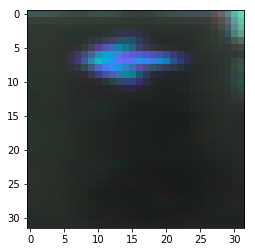

[0.]


In [372]:
import matplotlib.pyplot as plt

img = cv2.imread('/home/sadayal/Study/data/traffic_lights/train/red/1.0.png')
plt.imshow(img)
plt.show()

x = get_histogram(img, hist_bin_size)
pr = clf_load.predict(x) 

print(pr)

# Implement Traffic Light Detection using ssd_mobilenet_v1_coco_2018_01_28

In [380]:
import tensorflow as tf
from keras.models import load_model

class TLClassifier(object):
    def __init__(self):
        detect_model_name = 'ssd_mobilenet_v1_coco_2018_01_28'
        PATH_TO_CKPT = detect_model_name + '/frozen_inference_graph.pb'
        # setup tensorflow graph
        self.detection_graph = tf.Graph()

        # configuration for possible GPU use
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        # load frozen tensorflow detection model and initialize 
        # the tensorflow graph
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')
                self.sess = tf.Session(graph=self.detection_graph, config=config)
                self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
                # Each box represents a part of the image where a particular object was detected.
                self.boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
                # Each score represent how level of confidence for each of the objects.
                # Score is shown on the result image, together with the class label.
                self.scores =self.detection_graph.get_tensor_by_name('detection_scores:0')
                self.classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
                self.num_detections =self.detection_graph.get_tensor_by_name('num_detections:0')
    
    def get_localization(self, image):  
        category_index={10: {'id': 10, 'name': u'traffic light'}}  
        with self.detection_graph.as_default():
            image_expanded = np.expand_dims(image, axis=0)
            (boxes, scores, classes, num_detections) = self.sess.run(
                  [self.boxes, self.scores, self.classes, self.num_detections],
                  feed_dict={self.image_tensor: image_expanded})
            boxes=np.squeeze(boxes)
            classes =np.squeeze(classes)
            scores = np.squeeze(scores)
            return boxes, classes, scores
    def load_image_into_numpy_array(self, image):
        (im_width, im_height) = image.size
        return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8) 
    
    def box_normal_to_pixel(self, box, dim):
    
        height, width = dim[0], dim[1]
        box_pixel = [int(box[0]*height), int(box[1]*width), int(box[2]*height), int(box[3]*width)]
        return np.array(box_pixel)

In [381]:
tl_cls =TLClassifier()

In [384]:
from PIL import Image
img_full = Image.open('/home/sadayal/Study/data/rgb/train/2015-10-05-10-52-01_bag/25914.png')
img_full_np = tl_cls.load_image_into_numpy_array(img_full)

boxes, classes, scores = tl_cls.get_localization(img_full_np)
print(classes)

[ 3. 10.  3.  1. 10.  6.  3.  3. 10.  3. 10.  3.  3.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [386]:
traffic_boxes = []
dim = img_full_np.shape[0:2]
for i, cls in enumerate(classes):
    if cls == 10:
        print(i, boxes[i],scores[i])
        if scores[i]>0.35:
            traffic_boxes.append(tl_cls.box_normal_to_pixel(boxes[i], dim))


1 [0.18345012 0.4421409  0.2539333  0.46551254] 0.7454702
4 [0.17928827 0.3319013  0.2389768  0.35098124] 0.536896
8 [0.24635391 0.6453285  0.31347662 0.6721412 ] 0.384742
10 [0.18450518 0.30393597 0.24149169 0.32525036] 0.37166715


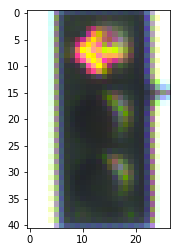

In [399]:
box = traffic_boxes[-1]
plt.imshow(img_full_np[box[0]:box[2],box[1]:box[3]])
plt.show()

In [400]:
x = get_histogram(cv2.resize(img_full_np[box[0]:box[2],box[1]:box[3],[2,1,0]],(32,32)), hist_bin_size)
pr = clf_load.predict(x) 
print(pr)

[0.]


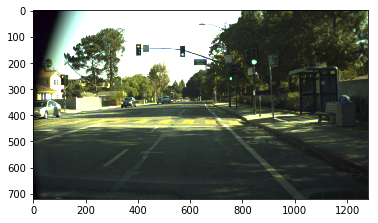

In [401]:
plt.imshow(img_full_np)
plt.show()